<a href="https://colab.research.google.com/github/minnji88/DeepLearning2020/blob/master/8_5%20%EC%A0%81%EB%8C%80%EC%A0%81_%EC%83%9D%EC%84%B1_%EC%8B%A0%EA%B2%BD%EB%A7%9D(GAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GAN은 생성된 이미지가 실제 이미지와 통계적으로 거의 구분이 되지 않도록 강제하여 아주 실제 같은 합성 이미지를 생성합니다. GAN은 2개의 네트워크로 구성됩니다.

- 생성자 네트워크(generator network) : 랜덤 벡터를 입력으로 받아 이를 합성된 이미지로 디코딩합니다.
- 판별자 네트워크(discriminator network) : 이미지를 입력으로 받아 훈련 세트에서 온 이미지인지, 생성자 네트워크가 만든 이미지 인지 판별합니다.

생성자 네트워크는 판별자 네트워크를 속이도록 훈련합니다. 훈련이 계속될수록 점점 더 실제와 같은 이미지를 생성하게 됩니다. 실제 이미지와 구분할 수 없는 인공적인 이미지를 만들어 판별자 네트워크가 두 이미지를 동일하게 보도록 만듭니다. 한편 판별자 네트워크는 생ㅅ겅된 이미지가 실제인지 판별하는 기준을 설정하면서 생성자의 능력 향상에 적응해 갑니다. 훈련이 끝나면 생성자는 입력 공간에 있는 어떤 포인트를 그럴듯한 이미지로 변환합니다. VAE와 달리 이 잠재 공간은 의미 있는 구조를 보장하지 않습니다. 특히 이 공간은 연속적이지 않습니다.


##  생성자
먼저 벡터(훈련하는 동안 잠재 공간에서 무작위로 샘플링됩니다)를 후보 이미지로 변환하는 generator 모델을 만들어 보죠. 

In [1]:
# 코드 8-29 GAN 생성자 네트워크
import keras
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# 입력을 16 × 16 크기의 128개 채널을 가진 특성 맵으로 변환합니다
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

# 합성곱 층을 추가합니다
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# 32 × 32 크기로 업샘플링합니다
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# 합성곱 층을 더 추가합니다
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# 32 × 32 크기의 1개 채널을 가진 특성 맵을 생성합니다
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense (Dense)                (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       104883

## 판별자

후보 이미지(진짜 혹은 가짜)를 입력으로 받고 두 개의 클래스로 분류하는 discriminator 모델을 만들겠습니다. 이 클래스는 ‘생성된 이미지’ 또는 ‘훈련 세트에서 온 진짜 이미지’입니다.

In [2]:
# 코드 8-30 GAN 판별자 네트워크
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# 드롭아웃 층을 넣는 것이 아주 중요합니다!
x = layers.Dropout(0.4)(x)

# 분류 층
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# 옵티마이저에서 (값을 지정하여) 그래디언트 클리핑을 사용합니다
# 안정된 훈련을 위해서 학습률 감쇠를 사용합니다
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 6, 6, 128)         0   

## 적대적 네트워크

마지막으로 생성자와 판별자를 연결하여 GAN을 설정합니다. 훈련할 때 생성자가 판별자를 속이는 능력이 커지도록 학습합니다. 이 모델은 잠재 공간의 포인트를 “진짜” 또는 “가짜”의 분류 결정으로 변환합니다. 훈련에 사용되는 타깃 레이블은 항상 ‘진짜 이미지’입니다. gan을 훈련하는 것은 discriminator가 가짜 이미지를 보았을 때 진짜라고 예측하도록 만들기 위해 generator의 가중치를 업데이트하는 것입니다. 훈련하는 동안 판별자를 동결(학습되지 않도록)하는 것이 아주 중요합니다. gan을 훈련할 때 가중치가 업데이트되지 않습니다. 판별자의 가중치가 훈련하는 동안 업데이트되면 판별자는 항상 “진짜”를 예측하도록 훈련됩니다.

In [3]:
# 판별자의 가중치가 훈련되지 않도록 설정합니다(gan 모델에만 적용됩니다)
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

##  DCGAN 훈련 방법

1. 잠재 공간에서 무작위로 포인트를 뽑습니다(랜덤 노이즈).
2. 이 랜덤 노이즈를 사용해 generator에서 이미지를 생성합니다.
3. 생성된 이미지와 진짜 이미지를 섞습니다.
4. 진짜와 가짜가 섞인 이미지와 이에 대응하는 타깃을 사용해 discriminator를 훈련합니다. 타깃은 “진짜”(실제 이미지일 경우) 또는 “가짜”(생성된 이미지일 경우)입니다.
5. 잠재 공간에서 무작위로 새로운 포인트를 뽑습니다.
6. 이 랜덤 벡터를 사용해 gan을 훈련합니다. 모든 타깃은 “진짜”로 설정합니다. 판별자가 생성된 이미지를 모두 “진짜 이미지”라고 예측하도록 생성자의 가중치를 업데이트합니다(gan 안에서 판별자는 동결되기 때문에 생성자만 업데이트합니다). 결국 생성자는 판별자를 속이도록 훈련합니다.

In [4]:
import os
from keras.preprocessing import image

# CIFAR10 데이터를 로드합니다
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# 개구리 이미지를 선택합니다(클래스 6)
x_train = x_train[y_train.flatten() == 6]

# 데이터를 정규화합니다
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = './gan_images/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

# 훈련 반복 시작
start = 0
for step in range(iterations):
    # 잠재 공간에서 무작위로 포인트를 샘플링합니다
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # 가짜 이미지를 디코딩합니다
    generated_images = generator.predict(random_latent_vectors)

    # 진짜 이미지와 연결합니다
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # 진짜와 가짜 이미지를 구분하여 레이블을 합칩니다
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # 레이블에 랜덤 노이즈를 추가합니다. 아주 중요합니다!
    labels += 0.05 * np.random.random(labels.shape)

    # discriminator를 훈련합니다
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # 잠재 공간에서 무작위로 포인트를 샘플링합니다
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # 모두 “진짜 이미지"라고 레이블을 만듭니다
    misleading_targets = np.zeros((batch_size, 1))

    # generator를 훈련합니다(gan 모델에서 discriminator의 가중치는 동결됩니다)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    # 중간 중간 저장하고 그래프를 그립니다
    if step % 100 == 0:
        # 모델 가중치를 저장합니다
        gan.save_weights('gan.h5')

        # 측정 지표를 출력합니다
        print('스텝 %s에서 판별자 손실: %s' % (step, d_loss))
        print('스텝 %s에서 적대적 손실: %s' % (step, a_loss))

        # 생성된 이미지 하나를 저장합니다
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # 비교를 위해 진짜 이미지 하나를 저장합니다
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

170500096/170498071 [==============================] - 2s 0us/step
스텝 0에서 판별자 손실: 0.69538813829422
스텝 0에서 적대적 손실: 0.6848281621932983
스텝 100에서 판별자 손실: 0.7358710169792175
스텝 100에서 적대적 손실: 0.8367697596549988
스텝 200에서 판별자 손실: 0.7032512426376343
스텝 200에서 적대적 손실: 0.7715943455696106
스텝 300에서 판별자 손실: 0.7030413150787354
스텝 300에서 적대적 손실: 0.7292850613594055
스텝 400에서 판별자 손실: 0.7039502859115601
스텝 400에서 적대적 손실: 0.7493795156478882
스텝 500에서 판별자 손실: 0.699881374835968
스텝 500에서 적대적 손실: 0.776049017906189
스텝 600에서 판별자 손실: 0.6910111308097839
스텝 600에서 적대적 손실: 0.7703516483306885
스텝 700에서 판별자 손실: 0.6961661577224731
스텝 700에서 적대적 손실: 0.7750411629676819
스텝 800에서 판별자 손실: 0.6884691119194031
스텝 800에서 적대적 손실: 0.7532947659492493
스텝 900에서 판별자 손실: 0.6823996305465698
스텝 900에서 적대적 손실: 0.8011649250984192
스텝 1000에서 판별자 손실: 0.6929710507392883
스텝 1000에서 적대적 손실: 0.7559084892272949
스텝 1100에서 판별자 손실: 0.6865993142127991
스텝 1100에서 적대적 손실: 0.7632786631584167
스텝 1200에서 판별자 손실: 0.708114504814148
스텝 1200에서 적대적 손실: 0.7437888979911804


In [5]:
import matplotlib.pyplot as plt

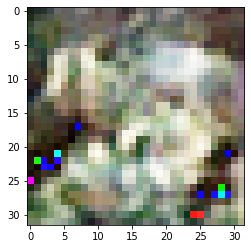

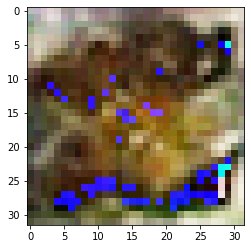

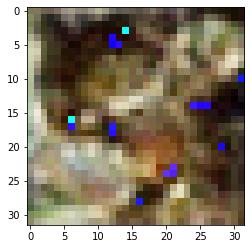

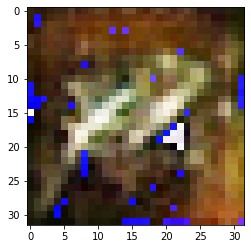

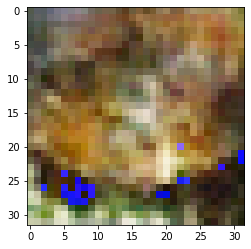

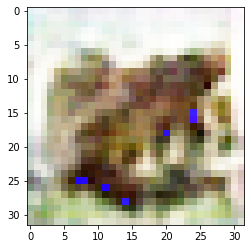

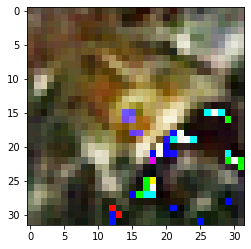

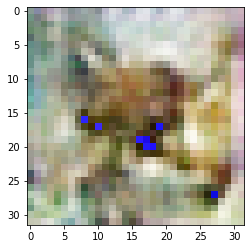

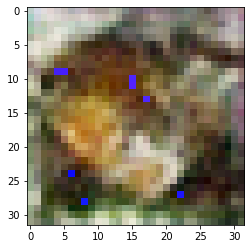

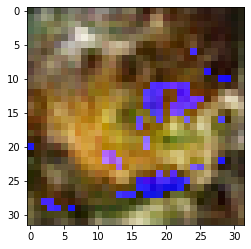

In [6]:
# 잠재 공간에서 랜덤한 포인트를 샘플링합니다
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# 가짜 이미지로 디코딩합니다
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()

훈련할 때 적대적 손실이 크게 증가할 수도 있습니다. 반면 판별자의 손실은 0으로 향합니다. 결국 판별자가 생성자를 압도하게됩니다. 이 케이스에는 판별자의 학습률을 낮추고 판별자의 드롭아웃 비율을 높여서 하면됩니다.